# 模型效果
## 改用deep-wide模型架构
### 三层卷积再分架构


## 对比（非lstm架构）
r2_train: 0.9947811961174011
r2_val: 0.9749422669410706
r2_a: 0.9464100454957816
r2_b: 0.6836000724611211

In [15]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random
from torchsummary import summary
from sklearn.model_selection import train_test_split
import shutil

'''Load data'''
temp_Qd = np.load('Data_processed/Qd_100.npy',allow_pickle=True).item()
temp_life = np.load('Data_processed/cycle_life.npy',allow_pickle=True).item()
all_capacity = np.load('Data_processed/all_capacity.npy',allow_pickle=True).item()
temp_Qd_all = []
temp_life_all = []
all_capacity_all = []

for key in temp_Qd.keys():
    temp_life_all.append(temp_life[key])
    all_capacity_all.append(all_capacity[key])
    temp_Qd_list = []
    for item in temp_Qd[key]:
        temp_Qd_list.append(item)
    temp_Qd_arr = np.asarray(temp_Qd_list)
    temp_Qd_all.append(temp_Qd_arr)
all_Qd_arr = np.asarray(temp_Qd_all)
cycle_life_arr = np.asarray(temp_life_all)    


'''Divide the dataset as the original paper stated'''
test_ind = np.hstack((np.arange(0,(41+43),2),83))
train_ind = np.arange(1,(41+43-1),2)
secondary_test_ind = np.arange(124-40,124)

all_keys = list(temp_Qd.keys())
train_keys = [all_keys[inx] for inx in train_ind]
test_keys = [all_keys[inx] for inx in test_ind]
secondary_test_keys = [all_keys[inx] for inx in secondary_test_ind]

cycle_life_arr=np.asarray(cycle_life_arr).reshape(-1,1)
max_label=np.max(cycle_life_arr)
cycle_life_arr=cycle_life_arr/max_label


train_Qds = np.asarray(all_Qd_arr)[train_ind]
train_cycle_lifes = np.asarray(cycle_life_arr)[train_ind]

test_Qd_a = np.asarray(all_Qd_arr)[test_ind]
test_cycle_life_a = np.asarray(cycle_life_arr)[test_ind]

test_Qd_b = np.asarray(all_Qd_arr)[secondary_test_ind]
test_cycle_life_b = np.asarray(cycle_life_arr)[secondary_test_ind]

train_Qd, _, train_cycle_life, _ = train_test_split(train_Qds, train_cycle_lifes, test_size=0.36, random_state=3)


In [16]:
import torch

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # 公用的前3层卷积层
        self.shared_cnn = torch.nn.Sequential(
            torch.nn.Conv2d(1, 8, kernel_size=(50, 50), stride=(5, 40)),
            torch.nn.BatchNorm2d(8),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=1),
            torch.nn.Dropout(p=0.2),
            
            torch.nn.Conv2d(8, 16, kernel_size=(2, 3), stride=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.Dropout(p=0.2),
            
            torch.nn.Conv2d(16, 32, kernel_size=(2, 3), stride=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.LeakyReLU(inplace=True),
        )

        # 插入Google net Inception模块
        self.inceptions = torch.nn.ModuleList([
            torch.nn.Sequential(
                torch.nn.Conv2d(32, 32, kernel_size=(1, 1), stride=1),
                torch.nn.BatchNorm2d(32),
                torch.nn.LeakyReLU(inplace=True)
            ),
            torch.nn.Sequential(
                torch.nn.Conv2d(32, 32, kernel_size=(1, 1), stride=1),
                torch.nn.BatchNorm2d(32),
                torch.nn.LeakyReLU(inplace=True),
                torch.nn.Conv2d(32, 32, kernel_size=(3, 3), stride=1, padding=1),
                torch.nn.BatchNorm2d(32),
                torch.nn.LeakyReLU(inplace=True)
            ),
            torch.nn.Sequential(
                torch.nn.Conv2d(32, 32, kernel_size=(1, 1), stride=1),
                torch.nn.BatchNorm2d(32),
                torch.nn.LeakyReLU(inplace=True),
                torch.nn.Conv2d(32, 32, kernel_size=(5, 5), stride=1, padding=2),  # Adjusted padding to 2
                torch.nn.BatchNorm2d(32),
                torch.nn.LeakyReLU(inplace=True)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
                torch.nn.Conv2d(32, 32, kernel_size=(1, 1), stride=1),
                torch.nn.BatchNorm2d(32),
            )
        ])

        # Adjusted input size to fully connected layer
        self.fc1 = torch.nn.Linear(19456, 1000)  # Updated size based on concatenated inception output
        self.drop_layer = torch.nn.Dropout(p=0.2)
        self.fc2 = torch.nn.Linear(1000, 1)

    def forward(self, x):
        try:
            # 先计算公用卷积层
            shared_out = self.shared_cnn(x)
            print(f"共享卷积层输出的形状: {shared_out.shape}")

            # 计算Inception模块的输出
            inception_outputs = [inception(shared_out) for inception in self.inceptions]
            combined = torch.cat(inception_outputs, dim=1)  # 在通道维度拼接 (dim=1)

            # 全连接层
            x = torch.relu(self.fc1(combined.view(combined.size(0), -1)))  # Flatten before fc
            x = self.drop_layer(x)
            x = self.fc2(x)
            x = torch.sigmoid(x)  # 使用sigmoid作为输出激活函数
            return x

        except Exception as e:
            print(f"Error occurred during forward pass: {e}")
            return None



In [17]:
import os
'''Data loader for Pytorch'''
input_train = torch.FloatTensor(train_Qd)
input_train = torch.unsqueeze(input_train, 1)
train_labels = torch.FloatTensor(train_cycle_life)

input_val = torch.FloatTensor(train_Qds)
input_val = torch.unsqueeze(input_val, 1)
val_labels = torch.FloatTensor(train_cycle_lifes)

input_test_a = torch.FloatTensor(test_Qd_a)
input_test_a = torch.unsqueeze(input_test_a, 1)
test_labels_a = torch.FloatTensor(test_cycle_life_a)

input_test_b = torch.FloatTensor(test_Qd_b)
input_test_b = torch.unsqueeze(input_test_b, 1)
test_labels_b = torch.FloatTensor(test_cycle_life_b)



seed = 17
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
np.random.seed(seed)  # Numpy module.
random.seed(seed)  # Python random module.
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.manual_seed(seed)    # reproducible    


net = Net()     # define the network
print(net)      # net architecture
# summary(net,(1,100,1000))

optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
loss_func = torch.nn.MSELoss() 

val_losses=[]

# 用于保存模型的最大数量
max_models_to_keep = 10
saved_models = []

for t in range(1000):
    net.train()
    train_prediction = net(input_train)
    train_loss = loss_func(train_prediction, train_labels)
   
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # 保存模型
    model_path = 'Target_model/net_parameters'+str(t)+'.pkl'
    torch.save({
        'epoch': t,
        'model_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()}, model_path)

    net.eval()
    with torch.no_grad():
        val_prediction = net(input_val)
        val_loss = loss_func(val_prediction, val_labels)
    print('Step = %d' % t, 'train_loss:', train_loss.data.numpy(), 'val_loss:', val_loss.data.numpy())
    val_losses.append(val_loss.item())

    # 添加当前模型及其验证损失
    saved_models.append((val_loss.item(), model_path))

    # 保持模型数量不超过max_models_to_keep
    if len(saved_models) > max_models_to_keep:
        # 找到验证损失最大的一组模型并删除
        saved_models.sort(key=lambda x: x[0])  # 排序，根据损失
        os.remove(saved_models.pop()[1])  # 删除损失最大的模型

# 'saved_models' 中现在只包含验证损失最小的前十个模型
'''选择损失最小的模型'''
best_index = val_losses.index(np.min(val_losses))
print(best_index)

'''复制验证损失最小的模型到最佳模型文件夹'''
if 1:
    shutil.copyfile('Target_model/net_parameters'+str(best_index)+'.pkl', 'Best_target_model/net_parameters.pkl')

'''重新加载最佳模型''' 
model = Net()
a = model.load_state_dict(torch.load('Best_target_model/net_parameters.pkl')['model_state_dict'])
optimizer.load_state_dict(torch.load('Best_target_model/net_parameters.pkl')['optimizer_state_dict'])



Net(
  (shared_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(50, 50), stride=(5, 40))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
    (5): Conv2d(8, 16, kernel_size=(2, 3), stride=(1, 1))
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
    (8): Dropout(p=0.2, inplace=False)
    (9): Conv2d(16, 32, kernel_size=(2, 3), stride=(1, 1))
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (inceptions): ModuleList(
    (0): Sequential(
      (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats

KeyboardInterrupt: 

mpe_train: 0.09981526
mpe_val: 0.09883615
mpe_a: 0.11256995163562106
mpe_b: 0.2824051062550563
rmse_train: 71.977295
rmse_val: 80.96326
rmse_a: 88.44246586025211
rmse_b: 333.2826503135139


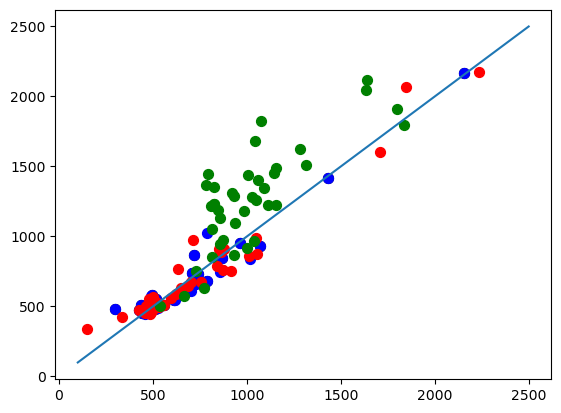

In [13]:

'''Prediction using the best model'''
predict_labels_a=[]
predict_labels_b=[]
predict_labels_train=[]
predict_labels_val = []
model.eval()
with torch.no_grad():
    predict_labels_a.append(model(input_test_a).data.numpy())
    predict_labels_b.append(model(input_test_b).data.numpy())
    
    predict_labels_train.append(model(input_train).data.numpy())   
    predict_labels_val.append(model(input_val).data.numpy())      


actual_label_arr_train=np.round(np.asarray(train_labels*max_label).reshape(-1,1))  
predict_label_arr_train=np.round(np.asarray(predict_labels_train).reshape(-1,1)*max_label)


actual_label_arr_val=np.round(np.asarray(val_labels*max_label).reshape(-1,1))   
predict_label_arr_val=np.round(np.asarray(predict_labels_val).reshape(-1,1)*max_label)


actual_label_arr_a=np.round(np.asarray(test_cycle_life_a*max_label).reshape(-1,1))   
predict_label_arr_a=np.round(np.asarray(predict_labels_a).reshape(-1,1)*max_label)


actual_label_arr_b=np.round(np.asarray(test_cycle_life_b * max_label).reshape(-1,1))   
predict_label_arr_b=np.round(np.asarray(predict_labels_b).reshape(-1,1)*max_label)


'''Plot the predicted cycle lives'''
plt.scatter(actual_label_arr_train, predict_label_arr_train,s=50,c='k')
plt.scatter(actual_label_arr_val, predict_label_arr_val,s=50,c='b')
plt.scatter(actual_label_arr_a, predict_label_arr_a,s=50,c='r')
plt.scatter(actual_label_arr_b, predict_label_arr_b,s=50,c='g')
plt.plot([100,2500],[100,2500])


'''Evaluation metrics'''
mpe_a=np.mean(np.abs(predict_label_arr_a-actual_label_arr_a)/actual_label_arr_a)
mpe_b=np.mean(np.abs(predict_label_arr_b-actual_label_arr_b)/actual_label_arr_b)
mpe_train = np.mean(np.abs(predict_label_arr_train-actual_label_arr_train)/actual_label_arr_train)
mpe_val = np.mean(np.abs(predict_label_arr_val-actual_label_arr_val)/actual_label_arr_val)


rmse_a=np.sqrt(np.mean((predict_label_arr_a-actual_label_arr_a)**2))
rmse_b=np.sqrt(np.mean((predict_label_arr_b-actual_label_arr_b)**2))
rmse_train=np.sqrt(np.mean((predict_label_arr_train-actual_label_arr_train)**2))
rmse_val=np.sqrt(np.mean((predict_label_arr_val-actual_label_arr_val)**2))


print ('mpe_train:',mpe_train)
print ('mpe_val:',mpe_val)
print ('mpe_a:',mpe_a)
print ('mpe_b:',mpe_b)

print ('rmse_train:', rmse_train)
print ('rmse_val:', rmse_val)
print ('rmse_a:', rmse_a)
print ('rmse_b:', rmse_b)

In [14]:
from sklearn.metrics import r2_score
r2_a = r2_score(actual_label_arr_a, predict_label_arr_a)
r2_b = r2_score(actual_label_arr_b, predict_label_arr_b)
r2_train = r2_score(actual_label_arr_train, predict_label_arr_train)
r2_val = r2_score(actual_label_arr_val, predict_label_arr_val)

print('r2_train:', r2_train)
print('r2_val:', r2_val)
print('r2_a:', r2_a)
print('r2_b:', r2_b)

r2_train: 0.9642801284790039
r2_val: 0.937027096748352
r2_a: 0.9487450590108414
r2_b: -0.3664594028772752
